# Time travel

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_groq import ChatGroq

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatGroq(model=os.getenv("GROQ_MODEL_NAME"))
llm_with_tools = llm.bind_tools(tools)

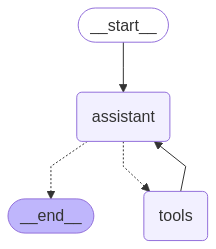

In [4]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [5]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_g4xh)
 Call ID: call_g4xh
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


### Browsing History

In [6]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='7b979261-61ef-4777-8521-bccc9e02d61e'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_g4xh', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 373, 'total_tokens': 392, 'completion_time': 0.069090909, 'prompt_time': 0.02408239, 'queue_time': 0.05424493100000001, 'total_time': 0.093173299}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--01f860fe-b660-4790-80b4-411b1e67ae56-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_g4xh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 373, 'output_tokens': 19, 'total_tokens': 392}), ToolMessage(content='6', name='multiply', id='6b33c988-a842-4110-8d48-badf4c11c28b'

In [7]:
all_states = [s for s in graph.get_state_history(thread)]

In [9]:
len(all_states)

5

In [11]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='7b979261-61ef-4777-8521-bccc9e02d61e')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03028b-853e-601e-8000-7dabe0b70653'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-05-13T18:33:09.781501+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03028b-853b-6c2e-bfff-bb0a40c9482e'}}, tasks=(PregelTask(id='062aa05a-7d43-e7e1-ee80-65672518cabf', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_g4xh', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 373, 

![img](https://camo.githubusercontent.com/8bfbb7c4ccc17b02d5facd27a3f6953723800870ac06c6d26e8e8eb5ce7215d0/68747470733a2f2f63646e2e70726f642e776562736974652d66696c65732e636f6d2f3635623863643732383335636565616364343434396135332f3636646262303338323131623534343839383537306265335f74696d652d74726176656c312e706e67)

### Replaying

![img](https://camo.githubusercontent.com/e741d4265a3a051ffbad7c6929a9207dadcda465b708201d032fd73df02ecbdc/68747470733a2f2f63646e2e70726f642e776562736974652d66696c65732e636f6d2f3635623863643732383335636565616364343434396135332f3636646262303338613062643334623534316337386662385f74696d652d74726176656c322e706e67)

In [13]:
to_replay = all_states[-2]

In [14]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='7b979261-61ef-4777-8521-bccc9e02d61e')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03028b-853e-601e-8000-7dabe0b70653'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-05-13T18:33:09.781501+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03028b-853b-6c2e-bfff-bb0a40c9482e'}}, tasks=(PregelTask(id='062aa05a-7d43-e7e1-ee80-65672518cabf', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_g4xh', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 373, 

In [15]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='7b979261-61ef-4777-8521-bccc9e02d61e')]}

In [16]:
to_replay.next

('assistant',)

In [17]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f03028b-853e-601e-8000-7dabe0b70653'}}

In [18]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ha5f)
 Call ID: call_ha5f
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


### Forking

![img](https://camo.githubusercontent.com/80e8b29ceb73669d1c1cb2550b320d5fa37fc401c4b009c1afb7edaf58cda76a/68747470733a2f2f63646e2e70726f642e776562736974652d66696c65732e636f6d2f3635623863643732383335636565616364343434396135332f3636646262303338663839663264383437656535633333365f74696d652d74726176656c332e706e67)

In [19]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='7b979261-61ef-4777-8521-bccc9e02d61e')]

In [20]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f03028b-853e-601e-8000-7dabe0b70653'}}

In [21]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='Multiply 5 and 3', 
                               id=to_fork.values["messages"][0].id)]},
)

In [22]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0302a1-cccf-6bd8-8001-5a1f6d8f4f33'}}

In [23]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='7b979261-61ef-4777-8521-bccc9e02d61e')]

In [24]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='7b979261-61ef-4777-8521-bccc9e02d61e')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0302a1-cccf-6bd8-8001-5a1f6d8f4f33'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='7b979261-61ef-4777-8521-bccc9e02d61e')]}}, 'step': 1, 'parents': {}, 'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03028b-853e-601e-8000-7dabe0b70653'}, created_at='2025-05-13T18:43:07.844076+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03028b-853e-601e-8000-7dabe0b70653'}}, tasks=(PregelTask(id='39f6e6cd-35b4-8466-6b5a-89cad0b32fc1', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [25]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_c726)
 Call ID: call_c726
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

The result of multiplying 5 and 3 is 15.


In [26]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='7b979261-61ef-4777-8521-bccc9e02d61e'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_c726', 'function': {'arguments': '{"a": 5, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 373, 'total_tokens': 392, 'completion_time': 0.166680443, 'prompt_time': 0.033107067, 'queue_time': 0.059402793, 'total_time': 0.19978751}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a23d21a5-6986-4bb6-a0d1-a083cc4a1c1e-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 3}, 'id': 'call_c726', 'type': 'tool_call'}], usage_metadata={'input_tokens': 373, 'output_tokens': 19, 'total_tokens': 392}), ToolMessage(content='15', name='multiply', id='224a5736-80c7-47f1-aba8-4a74d65c614c', tool_

In [27]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

In [28]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_n445', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'token_usage': {'completion_tokens': 19, 'prompt_tokens': 374, 'total_tokens': 393, 'completion_time': 0.069090909, 'prompt_time': 0.031841398, 'queue_time': 0.054882761999999995, 'total_time': 0.100932307}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--d10e8f11-bf36-4b3e-8f3f-24edfeed9669-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_n445', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 374, 'output_tokens': 19, 'total_tokens': 393}}


In [29]:
states = await client.threads.get_history(thread['thread_id'])
to_replay = states[-2]
to_replay

{'values': {'messages': [{'content': 'Multiply 2 and 3',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '5e674f25-a94f-4c81-afdb-e1205612726c',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': 'eb6835c6-dae4-cad6-5492-7f9df5dd171c',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': {'messages': [{'content': '',
      'additional_kwargs': {'tool_calls': [{'id': 'call_n445',
         'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'},
         'type': 'function'}]},
      'response_metadata': {'token_usage': {'completion_tokens': 19,
        'prompt_tokens': 374,
        'total_tokens': 393,
        'completion_time': 0.069090909,
        'prompt_time': 0.031841398,
        'queue_time': 0.054882761999999995,
        'total_time': 0.100932307},
       'model_name': 'llama-3.3-70b-versatil

In [30]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    checkpoint_id=to_replay['checkpoint_id']
):      
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '1f0302ad-b0e8-6288-9beb-70213e882162', 'attempt': 1}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '5e674f25-a94f-4c81-afdb-e1205612726c', 'example': False}]}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '5e674f25-a94f-4c81-afdb-e1205612726c', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_btn2', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'token_usage': {'completion_tokens': 19, 'prompt_tokens': 374, 'total_tokens': 393, 'completion_time': 0.069090909, 'prompt_time': 0.032375037, 'queue_time': 0.055120223, 'total_time': 0.101465946}, 'model_name': 'llama-3.3-70b-versatile', 

In [31]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=to_replay['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_0ns1', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'token_usage': {'completion_tokens': 19, 'prompt_tokens': 374, 'total_tokens': 393, 'completion_time': 0.089718869, 'prompt_time': 0.103931565, 'queue_time': 0.054431755, 'total_time': 0.193650434}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--f0a90237-1075-4f15-b939-9ff3c50815ff-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_0ns1', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 374, 'output_tokens': 19, 'total_tokens': 393}}


In [32]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_x7bq', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'token_usage': {'completion_tokens': 19, 'prompt_tokens': 374, 'total_tokens': 393, 'completion_time': 0.069090909, 'prompt_time': 0.026095763, 'queue_time': 0.057646685999999996, 'total_time': 0.095186672}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--fe7d8149-944d-4e4f-b337-4a50faf332a0-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_x7bq', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 374, 'output_tokens': 19, 'total_tokens': 393}}


In [33]:
states = await client.threads.get_history(thread['thread_id'])
to_fork = states[-2]
to_fork['values']

{'messages': [{'content': 'Multiply 2 and 3',
   'additional_kwargs': {},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': 'a29062de-3c0d-4134-9e16-23f15ce907ca',
   'example': False}]}

In [34]:
to_fork['values']['messages'][0]['id']

'a29062de-3c0d-4134-9e16-23f15ce907ca'

In [35]:
to_fork['next']

['assistant']

In [36]:
to_fork['checkpoint_id']

'1f0302ae-8d3d-688c-8000-5210b8fc5135'

In [37]:
forked_input = {"messages": HumanMessage(content="Multiply 3 and 3",
                                         id=to_fork['values']['messages'][0]['id'])}

forked_config = await client.threads.update_state(
    thread["thread_id"],
    forked_input,
    checkpoint_id=to_fork['checkpoint_id']
)

In [38]:
forked_config

{'checkpoint': {'thread_id': '0cf4afd6-cb52-4b65-be31-7d3709ace6c7',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0302b0-7f45-607a-8001-8cddfb2a87aa'},
 'configurable': {'thread_id': '0cf4afd6-cb52-4b65-be31-7d3709ace6c7',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0302b0-7f45-607a-8001-8cddfb2a87aa'},
 'checkpoint_id': '1f0302b0-7f45-607a-8001-8cddfb2a87aa'}

In [39]:
states = await client.threads.get_history(thread['thread_id'])
states[0]

{'values': {'messages': [{'content': 'Multiply 3 and 3',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'a29062de-3c0d-4134-9e16-23f15ce907ca',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': '22a5de95-e173-d38e-d93b-bf05a3111e6b',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': None}],
 'metadata': {'graph_id': 'agent',
  'thread_id': '0cf4afd6-cb52-4b65-be31-7d3709ace6c7',
  'checkpoint_id': '1f0302ae-8d3d-688c-8000-5210b8fc5135',
  'checkpoint_ns': '',
  'user-agent': 'langgraph-sdk-py/0.1.69',
  'x-request-id': 'eca39265-40fc-41b2-a3df-190b44229366',
  'langgraph_auth_user': None,
  'langgraph_auth_user_id': '',
  'langgraph_auth_permissions': [],
  'langgraph_request_id': 'eca39265-40fc-41b2-a3df-190b44229366',
  'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'user_id': '',
  'creat

In [42]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=forked_config['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_hmnj', 'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'token_usage': {'completion_tokens': 19, 'prompt_tokens': 374, 'total_tokens': 393, 'completion_time': 0.069090909, 'prompt_time': 0.030441267, 'queue_time': 0.06015041199999999, 'total_time': 0.099532176}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--ea896a24-30ea-4598-8e88-8e7e66548637-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 3, 'b': 3}, 'id': 'call_hmnj', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 374, 'output_tokens': 19, 'total_tokens': 393}}
